# Benchmarking Politifact Suite

In [1]:
from langchain_community.llms import Ollama
from factCheck import factCheckSingleClaim, factCheckSingleClaimNoContext

OLLAMA_HOST = "http://host.docker.internal:11434" # for when running within docker image
# OLLAMA_HOST = "http://localhost:11434"
 
ollama3 = Ollama(model="llama3", base_url=OLLAMA_HOST)
ollama32 = Ollama(model="llama3.2", base_url=OLLAMA_HOST)

claimCount = 100

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from sklearn.metrics import accuracy_score, f1_score

# Evaluation function
def evaluate_model(predictions, y):
    for idx in range(len(predictions)):
        if y[idx] in predictions[idx]:
            predictions[idx] = y[idx];
        else:
            predictions[idx] = predictions[idx][0];
    
    # Ensure predictions and dataset labels are aligned
    accuracy = accuracy_score(y, predictions)
    f1 = f1_score(y, predictions, average='weighted')
    return accuracy, f1

In [3]:
from benchmarking.politifact.politifactEval import get_politifact_sample

dfPol = get_politifact_sample(claimCount, './benchmarking/politifact/politifact_factcheck_data.json', 42)

In [4]:
import time
from datetime import datetime
start_time = time.time()

polMapping = {
    "true": ["true"],
    "mostly true": ["mostly true", "half-true"],
    "mostly false": ["mostly false", "half-true"],
    "false": ["false", "pants-fire"],
    "not enough evidence": ["Not Enough Evidence"]
}

modelResults = [{'name': 'FactCheck3'}, {'name': 'FactCheck32'}, {'name': 'Llama3'}, {'name': 'Llama32'}]
for modelIndex, model in enumerate([ollama3, ollama32]):
    # FactCheckLLM check
    origPred = []
    polPred = []
    responses = []
    for row in dfPol.iterrows(): 
        pred = await factCheckSingleClaim(row[1]['statement'], model)
        origPred.append(pred['label'].lower())
        pred['label'] = polMapping[pred['label'].lower()]
        polPred.append(pred['label'])
        responses.append(pred['reply'])
        
    modelResults[modelIndex]['dataset'] = 'POLITIFACT';
    modelResults[modelIndex]['original-prediction'] = origPred;
    modelResults[modelIndex]['mapped-predictions'] = polPred;
    modelResults[modelIndex]['res'] = responses;
    
    acc, f1 = evaluate_model(polPred, dfPol['verdict'].values)
    modelResults[modelIndex]['acc'] = acc
    modelResults[modelIndex]['f1'] = f1
    
    # base model check
    origPred = []
    polPred = []
    responses = []
    for row in dfPol.iterrows(): 
        pred = await factCheckSingleClaimNoContext(row[1]['statement'], model)
        origPred.append(pred['label'].lower())
        pred['label'] = polMapping[pred['label'].lower()]
        polPred.append(pred['label'])
        responses.append(pred['reply'])
        
    modelResults[modelIndex+2]['dataset'] = 'POLITIFACT';
    modelResults[modelIndex+2]['original-prediction'] = origPred;
    modelResults[modelIndex+2]['mapped-predictions'] = polPred;
    modelResults[modelIndex]['res'] = responses;
    
    acc, f1 = evaluate_model(polPred, dfPol['verdict'].values)
    modelResults[modelIndex+2]['acc'] = acc
    modelResults[modelIndex+2]['f1'] = f1

end_time = time.time()
elapsed_time = end_time - start_time
minutes, seconds = divmod(elapsed_time, 60)
print(f"{int(minutes)} minutes and {seconds:.2f} seconds")

CLAIM: Jeb Bush: "Barack Obama will somehow manage to add more than $8 trillion to the national debt, which is more debt than the 43 presidents who held office before him compiled together."
FactCheck Articles: []
News Articles: []
Snopes Articles: []
Politifact Articles: [{'title': '"Barack Obama will somehow manage to add more than $8 trillion to the national debt, which is more debt than the 43 presidents who held office before him compiled together."', 'url': 'https://www.politifact.com/factchecks/2016/feb/18/jeb-bush/jeb-bush-says-barack-obama-will-add-more-debt-all-/'}, {'title': '"President Trump’s Republican Party will create more debt in one year than was generated in the first 200 years of America’s existence."', 'url': 'https://www.politifact.com/factchecks/2018/sep/12/joe-scarborough/will-trump-gop-create-more-debt-one-year-first-200/'}]
CLAIM: Donald Trump: Says President Obama's "grandmother in Kenya said he was born in Kenya and she was there and witnessed the birth."
Fa

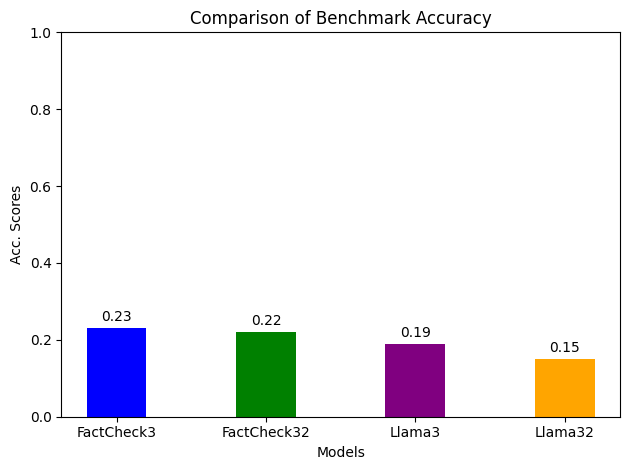

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Benchmark data
models =  [item["name"] for item in modelResults]
acc = [item["acc"] for item in modelResults]
f1 = [item["f1"] for item in modelResults]

# Bar chart parameters
x = np.arange(len(models))  # Position of bars
width = 0.4  # Width of bars

# Create the plot
fig, ax = plt.subplots()
bars = ax.bar(x, acc, width, color=['blue', 'green', 'purple', 'orange'])

# Add labels, title, and custom ticks
ax.set_xlabel('Models')
ax.set_ylabel('Acc. Scores')
ax.set_title('Comparison of Benchmark Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)  # Adjust y-axis range if needed
ax.bar_label(bars, fmt='%.2f', padding=3)  # Add values on top of bars

# Show the chart
plt.tight_layout()
plt.show()

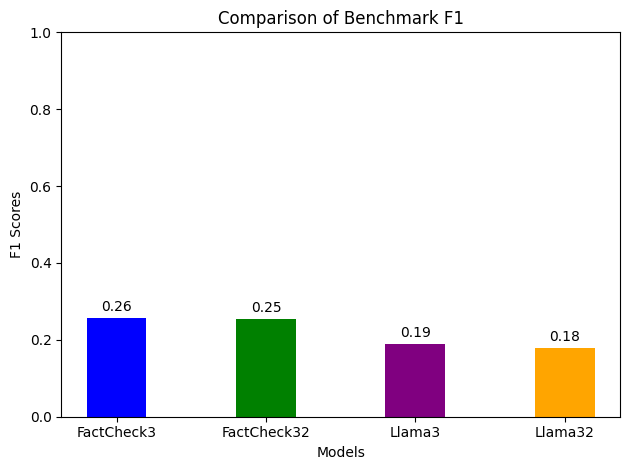

In [6]:
# Bar chart parameters
x = np.arange(len(models))  # Position of bars
width = 0.4  # Width of bars

# Create the plot
fig, ax = plt.subplots()
bars = ax.bar(x, f1, width, color=['blue', 'green', 'purple', 'orange'])

# Add labels, title, and custom ticks
ax.set_xlabel('Models')
ax.set_ylabel('F1 Scores')
ax.set_title('Comparison of Benchmark F1')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1)  # Adjust y-axis range if needed
ax.bar_label(bars, fmt='%.2f', padding=3)  # Add values on top of bars

# Show the chart
plt.tight_layout()
plt.show()

In [7]:
import pickle

feverResults = (dfPol['statement'].values, modelResults)

# Save to Pickle file
with open("benchmarking/politifact/results4.pkl", "wb") as f:
    pickle.dump(feverResults, f)

# # Load from Pickle file
# with open("benchmarking/AVERITEC/results.pkl", "rb") as f:
#     loaded_data = pickle.load(f)